In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

In [39]:
from f2_spade import *

In [40]:
def imp(x):
    if(x == 1 or x == 0):
        return 0
    return -(x*np.log2(x))-((1-x)*np.log2(1-x))
    #return x*(1-x)


In [41]:
def check_subsequence(a,b):
    # This function check if b is a subsequence of a
    # a is the possible supersequence
    # b is the possible subsequence
    try:
        if len(b)<len(a):
            start=a.index(b[0])
            count=0
            for idx in range(len(a)-start):
                if count<len(b) and a[start+idx]==b[count]:
                    count+=1
            if count==len(b):
                return True
        return False
    except:
        return False

In [42]:
def k_select_closed(positive_seqs,negative_seqs,k,P,N,total,score_type='wracc', printing=False):
    '''
    This function finds tok-k closed sequences with respect to a score defined by score_type ('wracc','abswracc','infogain')
    '''
    wracc_left=(P/total)*(N/total)
    Positive_seq_Discoverd=set(positive_seqs.keys())
    Negative_seq_Discoverd=set(negative_seqs.keys())
    To_discover=Positive_seq_Discoverd.union(Negative_seq_Discoverd)
    sequences={}
    
    for sequence in To_discover:
        p=positive_seqs.get(sequence,0)
        n=negative_seqs.get(sequence,0)
        if score_type=='wracc':
            score=wracc_left*((p/P)-(n/N))
        elif score_type=='abswracc':
            score=abs(wracc_left*((p/P)-(n/N)))
        elif score_type=='infogain':

            score=imp(P/total)-(((p+n)/(total))*imp(p/(p+n)))
            if (P != p or N!= n):
                #print((((P+N-p-n)/(total))*imp((P-p)/(P+N-p-n))))
                score-=(((P+N-p-n)/(total))*imp((P-p)/(P+N-p-n)))
        sequences[sequence]=[p,n,np.round(score,5),p+n]
    
    sorted_sequences=sorted(sequences.items(), key=lambda item: item[1][2],reverse=True)
    i=1
    j=0
    k_selected=[]
    prev=sorted_sequences[0][1][2]
    for sequence in sorted_sequences:
        if sequence[1][2]!=prev:
            i+=1
            prev=sequence[1][2]
        if i<=k:
            status=True
            possible_super=sequence[0]
            idx=0
            while idx<len(k_selected):
                possible_subsequence=k_selected[idx]
                if check_subsequence(possible_super,possible_subsequence):
                    if sequences[possible_super][3]==sequences[possible_subsequence][3]:

                        p=k_selected.pop(idx)
                        idx-=1
                
                if check_subsequence(possible_subsequence,possible_super):
                    if sequences[possible_super][3]==sequences[possible_subsequence][3]:
                        status=False
                idx+=1
            if status:
                k_selected.append(possible_super)
            j+=1
        else:
            break
    if printing==True:
        for sequence in k_selected:
            out='['+', '.join(list(sequence))+']'
            print(out,sequences[sequence][0],sequences[sequence][1],sequences[sequence][2])
            
    return set(k_selected)

# Example of running the algorithm to check if everything in f2_spade works

## wracc

In [43]:
# TODO: read the dataset files and call your miner to print the top k itemsets
ds_positive=Dataset_Sequence('p-positive.txt')
P=ds_positive.trans_num() #  The number of transactions in positive class
ds_negative=Dataset_Sequence('p-negative.txt')
N=ds_negative.trans_num() #  The number of transactions in negative class
total=P+N
#print('P=',P,"N=",N,'Total=',total)
#print(ds_positive.transactions)
positive_seqs=f2_spade(ds_positive, 0.02,printing=False)
negative_seqs=f2_spade(ds_negative, 0.05,printing=False)
top_k_seq=k_select_closed(positive_seqs,negative_seqs,5,P,N,total,score_type='wracc',printing=True)

[Y] 314 99 0.18332
[E, Y] 190 28 0.13167
[Y, G] 175 22 0.12373
[P, Y] 174 22 0.12295
[D, Y] 174 25 0.121


## abswracc

In [47]:
# TODO: read the dataset files and call your miner to print the top k itemsets
ds_positive=Dataset_Sequence('p-positive.txt')
P=ds_positive.trans_num() #  The number of transactions in positive class
ds_negative=Dataset_Sequence('p-negative.txt')
N=ds_negative.trans_num() #  The number of transactions in negative class
total=P+N
#print('P=',P,"N=",N,'Total=',total)
#print(ds_positive.transactions)
positive_seqs=f2_spade(ds_positive, 0.02,printing=False)
negative_seqs=f2_spade(ds_negative, 0.05,printing=False)
top_k_seq=k_select_closed(positive_seqs,negative_seqs,5,P,N,total,score_type='abswracc',printing=True)

[Y] 314 99 0.18332
[R, S] 73 344 0.16604
[R, R, S] 16 231 0.13755
[R, R] 58 279 0.13562
[E, Y] 190 28 0.13167


## Information Gain

In [49]:
# TODO: read the dataset files and call your miner to print the top k itemsets
ds_positive=Dataset_Sequence('p-positive.txt')
P=ds_positive.trans_num() #  The number of transactions in positive class
ds_negative=Dataset_Sequence('p-negative.txt')
N=ds_negative.trans_num() #  The number of transactions in negative class
total=P+N
#print('P=',P,"N=",N,'Total=',total)
#print(ds_positive.transactions)
positive_seqs=f2_spade(ds_positive, 0.02,printing=False)
negative_seqs=f2_spade(ds_negative, 0.05,printing=False)
top_k_seq=k_select_closed(positive_seqs,negative_seqs,5,P,N,total,score_type='infogain',printing=True)

[Y] 314 99 0.52112
[R, S] 73 344 0.36545
[R, R, S] 16 231 0.27738
[E, Y] 190 28 0.2524
[R] 152 367 0.24037


# Machine Learning Performance Comparision

## 1- function for creating Pandas data frame

In [19]:
def Create_df(seqList,positiveTrans,negativeTrans):
    '''
    seqList=[]
    for i in selected:
        seqs=list(selected[i])
        for seq in seqs:
            seqList.append(seq)
    '''
    frame = pd.DataFrame(columns = list(seqList)+['label'])
    counter=0
    # Adding Positive Class
    for transaction in positiveTrans:
        seqObserved=[]
        for seq in seqList:
            seqObserved.append(int(check_subsequence(transaction,seq)))
        seqObserved.append(True)
        frame.loc[counter]=seqObserved
        counter+=1
    # Adding Negative Class
    for transaction in negativeTrans:
        seqObserved=[]
        for seq in seqList:
            seqObserved.append(int(check_subsequence(transaction,seq)))
        seqObserved.append(False)
        frame.loc[counter]=seqObserved
        counter+=1
    frame = frame.sample(frac=1).reset_index(drop=True)
    return frame

In [53]:
# TODO: read the dataset files and call your miner to print the top k itemsets
ds_positive=Dataset_Sequence('positive.txt')
P=ds_positive.trans_num() #  The number of transactions in positive class
ds_negative=Dataset_Sequence('negative.txt')
N=ds_negative.trans_num() #  The number of transactions in negative class
total=P+N
#print('P=',P,"N=",N,'Total=',total)
#print(ds_positive.transactions)
positive_seqs=f2_spade(ds_positive, 0.02,printing=False)
negative_seqs=f2_spade(ds_negative, 0.05,printing=False)
top_k_seq=k_select_closed(positive_seqs,negative_seqs,6,P,N,total,score_type='wracc')

In [54]:
frame=Create_df(top_k_seq,ds_positive.transactions,ds_negative.transactions)

In [55]:
frame.sample(5)

,"(A, A, C, A)","(A, C, A)","(A, B, A)","(A, C, C, A)","(A, A)","(A, C, C, B, A, B)","(A, B, B, A, C, A)","(A, A, B, C, C, A)","(A, C, C, A, C, A)","(A, A, B)","(A, B, C, A)",label
6,1,1,1,1,1,0,0,0,0,1,1,True
4,0,1,1,1,1,0,0,0,0,1,1,False
0,0,0,0,0,1,0,0,0,0,0,0,False
3,0,0,0,0,0,0,0,0,0,0,0,False
2,1,1,1,0,1,0,0,0,0,0,1,True


### 1-1 Running Experiment on Machine Learning (Example) (Logistic Regression and Decision Tree)

#### 1-1-1 Protein Dataset with k=10

In [66]:
# TODO: read the dataset files and call your miner to print the top k itemsets
ds_positive=Dataset_Sequence('p-positive.txt')
P=ds_positive.trans_num() #  The number of transactions in positive class
ds_negative=Dataset_Sequence('p-negative.txt')
N=ds_negative.trans_num() #  The number of transactions in negative class
total=P+N
#print('P=',P,"N=",N,'Total=',total)
#print(ds_positive.transactions)
positive_seqs=f2_spade(ds_positive, 0.02,printing=False)
negative_seqs=f2_spade(ds_negative, 0.05,printing=False)

#### wracc

In [25]:
top_k_seq=k_select_closed(positive_seqs,negative_seqs,10,P,N,total,score_type='wracc')
frame=Create_df(top_k_seq,ds_positive.transactions,ds_negative.transactions)
X_train, X_test, y_train, y_test = train_test_split(frame.iloc[:,:-1], frame.iloc[:,-1], test_size=0.3, random_state=42)
lr = LogisticRegression(random_state=0).fit(X_train, y_train.astype(int))
print('Logistic Regression:')
print('\tTraining Accuracy:',lr.score(X_train, y_train.astype(int)))
print('\tTest Accuracy:',lr.score(X_test, y_test.astype(int)))
dt = DecisionTreeClassifier(random_state=0).fit(X_train, y_train.astype(int))
print('Decision Tree:')
print('\tTraining Accuracy:',dt.score(X_train, y_train.astype(int)))
print('\tTest Accuracy:',dt.score(X_test, y_test.astype(int)))

Logistic Regression:
	Training Accuracy: 0.9197530864197531
	Test Accuracy: 0.8851674641148325
Decision Tree:
	Training Accuracy: 0.977366255144033
	Test Accuracy: 0.8947368421052632


#### abswracc

In [70]:
top_k_seq=k_select_closed(positive_seqs,negative_seqs,10,P,N,total,score_type='abswracc')
frame=Create_df(top_k_seq,ds_positive.transactions,ds_negative.transactions)
X_train, X_test, y_train, y_test = train_test_split(frame.iloc[:,:-1], frame.iloc[:,-1], test_size=0.3, random_state=42)
lr = LogisticRegression(random_state=0).fit(X_train, y_train.astype(int))
print('Logistic Regression:')
print('\tTraining Accuracy:',lr.score(X_train, y_train.astype(int)))
print('\tTest Accuracy:',lr.score(X_test, y_test.astype(int)))
dt = DecisionTreeClassifier(random_state=0).fit(X_train, y_train.astype(int))
print('Decision Tree:')
print('\tTraining Accuracy:',dt.score(X_train, y_train.astype(int)))
print('\tTest Accuracy:',dt.score(X_test, y_test.astype(int)))

Logistic Regression:
	Training Accuracy: 0.9423868312757202
	Test Accuracy: 0.9617224880382775
Decision Tree:
	Training Accuracy: 0.9547325102880658
	Test Accuracy: 0.9521531100478469


#### information gain

In [69]:
top_k_seq=k_select_closed(positive_seqs,negative_seqs,10,P,N,total,score_type='infogain')
frame=Create_df(top_k_seq,ds_positive.transactions,ds_negative.transactions)
X_train, X_test, y_train, y_test = train_test_split(frame.iloc[:,:-1], frame.iloc[:,-1], test_size=0.3, random_state=42)
lr = LogisticRegression(random_state=0).fit(X_train, y_train.astype(int))
print('Logistic Regression:')
print('\tTraining Accuracy:',lr.score(X_train, y_train.astype(int)))
print('\tTest Accuracy:',lr.score(X_test, y_test.astype(int)))
dt = DecisionTreeClassifier(random_state=0).fit(X_train, y_train.astype(int))
print('Decision Tree:')
print('\tTraining Accuracy:',dt.score(X_train, y_train.astype(int)))
print('\tTest Accuracy:',dt.score(X_test, y_test.astype(int)))

Logistic Regression:
	Training Accuracy: 0.9567901234567902
	Test Accuracy: 0.937799043062201
Decision Tree:
	Training Accuracy: 0.9691358024691358
	Test Accuracy: 0.9282296650717703


#### 1-1-2 Reuters Dataset with k=10

## Warning: Due to the size of Reuters Data set, we could not run the experiments on this data set 

In [71]:
# TODO: read the dataset files and call your miner to print the top k itemsets
ds_positive=Dataset_Sequence('r-positive.txt')
P=ds_positive.trans_num() #  The number of transactions in positive class
ds_negative=Dataset_Sequence('r-negative.txt')
N=ds_negative.trans_num() #  The number of transactions in negative class
total=P+N
#print('P=',P,"N=",N,'Total=',total)
#print(ds_positive.transactions)
positive_seqs=f2_spade(ds_positive, 0.02,printing=False)
negative_seqs=f2_spade(ds_negative, 0.05,printing=False)

In [74]:
import pickle 
r_pos_seqs=open('r_pos_seqs.p','wb')
pickle.dump(positive_seqs,r_pos_seqs)
r_neg_seqs=open('r_neg_seqs.p','wb')
pickle.dump(negative_seqs,r_neg_seqs)

#### wracc

In [ ]:
top_k_seq=k_select_closed(positive_seqs,negative_seqs,10,P,N,total,score_type='wracc')
frame=Create_df(top_k_seq,ds_positive.transactions,ds_negative.transactions)
X_train, X_test, y_train, y_test = train_test_split(frame.iloc[:,:-1], frame.iloc[:,-1], test_size=0.3, random_state=42)
lr = LogisticRegression(random_state=0).fit(X_train, y_train.astype(int))
print('Logistic Regression:')
print('\tTraining Accuracy:',lr.score(X_train, y_train.astype(int)))
print('\tTest Accuracy:',lr.score(X_test, y_test.astype(int)))
dt = DecisionTreeClassifier(random_state=0).fit(X_train, y_train.astype(int))
print('Decision Tree:')
print('\tTraining Accuracy:',dt.score(X_train, y_train.astype(int)))
print('\tTest Accuracy:',dt.score(X_test, y_test.astype(int)))

#### abswracc

In [ ]:
top_k_seq=k_select_closed(positive_seqs,negative_seqs,10,P,N,total,score_type='abswracc')
frame=Create_df(top_k_seq,ds_positive.transactions,ds_negative.transactions)
X_train, X_test, y_train, y_test = train_test_split(frame.iloc[:,:-1], frame.iloc[:,-1], test_size=0.3, random_state=42)
lr = LogisticRegression(random_state=0).fit(X_train, y_train.astype(int))
print('Logistic Regression:')
print('\tTraining Accuracy:',lr.score(X_train, y_train.astype(int)))
print('\tTest Accuracy:',lr.score(X_test, y_test.astype(int)))
dt = DecisionTreeClassifier(random_state=0).fit(X_train, y_train.astype(int))
print('Decision Tree:')
print('\tTraining Accuracy:',dt.score(X_train, y_train.astype(int)))
print('\tTest Accuracy:',dt.score(X_test, y_test.astype(int)))

#### Information Gain

In [ ]:
top_k_seq=k_select_closed(positive_seqs,negative_seqs,10,P,N,total,score_type='infogain')
frame=Create_df(top_k_seq,ds_positive.transactions,ds_negative.transactions)
X_train, X_test, y_train, y_test = train_test_split(frame.iloc[:,:-1], frame.iloc[:,-1], test_size=0.3, random_state=42)
lr = LogisticRegression(random_state=0).fit(X_train, y_train.astype(int))
print('Logistic Regression:')
print('\tTraining Accuracy:',lr.score(X_train, y_train.astype(int)))
print('\tTest Accuracy:',lr.score(X_test, y_test.astype(int)))
dt = DecisionTreeClassifier(random_state=0).fit(X_train, y_train.astype(int))
print('Decision Tree:')
print('\tTraining Accuracy:',dt.score(X_train, y_train.astype(int)))
print('\tTest Accuracy:',dt.score(X_test, y_test.astype(int)))

## 1-2 Comparing the performance of the algorithms (Closed- wracc,abswracc, and infogain) with different k

### Protein Dataset

In [24]:

# Finding all candidate sequence
ds_positive=Dataset_Sequence('p-positive.txt')
P=ds_positive.trans_num() #  The number of transactions in positive class
ds_negative=Dataset_Sequence('p-negative.txt')
N=ds_negative.trans_num() #  The number of transactions in negative class
total=P+N
#print('P=',P,"N=",N,'Total=',total)
#print(ds_positive.transactions)
positive_seqs=f2_spade(ds_positive, 0.02,printing=False)
negative_seqs=f2_spade(ds_negative, 0.05,printing=False)

### Closed Wracc

Current k:  5
Current k:  10
Current k:  20
Current k:  30
Current k:  40
Current k:  50
Current k:  60
Current k:  70
Current k:  80
Current k:  90
Current k:  100


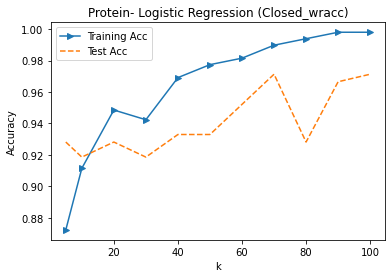

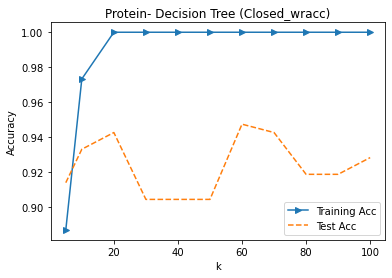

In [29]:
lr_train_acc=[]
lr_test_acc=[]
dt_train_acc=[]
dt_test_acc=[]

KS=[5,10,20,30,40,50,60,70,80,90,100]
for k in KS:
    print('Current k: ',k)
    top_k_seq=k_select_closed(positive_seqs,negative_seqs,k,P,N,total,score_type='wracc')
    frame=Create_df(top_k_seq,ds_positive.transactions,ds_negative.transactions)# creating the dataframe
    X_train, X_test, y_train, y_test = train_test_split(frame.iloc[:,:-1], frame.iloc[:,-1], test_size=0.3, random_state=42)
    """
    Logistic Regression
    """
    lr = LogisticRegression(random_state=0).fit(X_train, y_train.astype(int))
    lr_train_acc.append(lr.score(X_train, y_train.astype(int)))
    lr_test_acc.append(lr.score(X_test, y_test.astype(int)))
        
    """
    Decision Tree
    """
    dt = DecisionTreeClassifier(random_state=0).fit(X_train, y_train.astype(int))
    dt_train_acc.append(dt.score(X_train, y_train.astype(int)))
    dt_test_acc.append(dt.score(X_test, y_test.astype(int)))
    
## Plotting
plt.figure(1)
plt.plot(KS,lr_train_acc,'->',label='Training Acc')
plt.plot(KS,lr_test_acc,'--',label='Test Acc')
#plt.fill_between(KS,np.array(lr_train_acc)-0.002,np.array(lr_train_acc)+0.002,color='gray', alpha=0.2)
#plt.xlim(0, 10)
plt.title('Protein- Logistic Regression (Closed_wracc)')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Protein-Closedwracc-Logi.png')

plt.figure(2)
plt.plot(KS,dt_train_acc,'->',label='Training Acc')
plt.plot(KS,dt_test_acc,'--',label='Test Acc')
plt.title('Protein- Decision Tree (Closed_wracc)')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Protein-Closedwracc-DecTr.png')

### Closed absWracc

Current k:  5
Current k:  10
Current k:  20
Current k:  30
Current k:  40
Current k:  50
Current k:  60
Current k:  70
Current k:  80
Current k:  90
Current k:  100


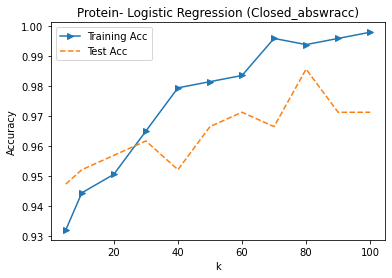

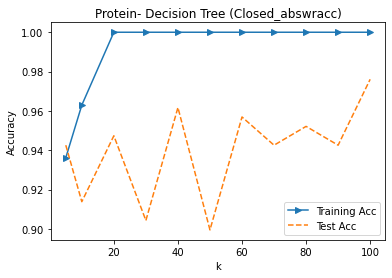

In [30]:
lr_train_acc=[]
lr_test_acc=[]
dt_train_acc=[]
dt_test_acc=[]

KS=[5,10,20,30,40,50,60,70,80,90,100]
for k in KS:
    print('Current k: ',k)
    top_k_seq=k_select_closed(positive_seqs,negative_seqs,k,P,N,total,score_type='abswracc')
    frame=Create_df(top_k_seq,ds_positive.transactions,ds_negative.transactions)# creating the dataframe
    X_train, X_test, y_train, y_test = train_test_split(frame.iloc[:,:-1], frame.iloc[:,-1], test_size=0.3, random_state=42)
    """
    Logistic Regression
    """
    lr = LogisticRegression(random_state=0).fit(X_train, y_train.astype(int))
    lr_train_acc.append(lr.score(X_train, y_train.astype(int)))
    lr_test_acc.append(lr.score(X_test, y_test.astype(int)))
        
    """
    Decision Tree
    """
    dt = DecisionTreeClassifier(random_state=0).fit(X_train, y_train.astype(int))
    dt_train_acc.append(dt.score(X_train, y_train.astype(int)))
    dt_test_acc.append(dt.score(X_test, y_test.astype(int)))
    
## Plotting
plt.figure(1)
plt.plot(KS,lr_train_acc,'->',label='Training Acc')
plt.plot(KS,lr_test_acc,'--',label='Test Acc')
#plt.fill_between(KS,np.array(lr_train_acc)-0.002,np.array(lr_train_acc)+0.002,color='gray', alpha=0.2)
#plt.xlim(0, 10)
plt.title('Protein- Logistic Regression (Closed_abswracc)')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Protein-Closedabswracc-Logi.png')

plt.figure(2)
plt.plot(KS,dt_train_acc,'->',label='Training Acc')
plt.plot(KS,dt_test_acc,'--',label='Test Acc')
plt.title('Protein- Decision Tree (Closed_abswracc)')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Protein-Closedabswracc-DecTr.png')

### Closed infogain

Current k:  5
Current k:  10
Current k:  20
Current k:  30
Current k:  40
Current k:  50
Current k:  60
Current k:  70
Current k:  80
Current k:  90
Current k:  100


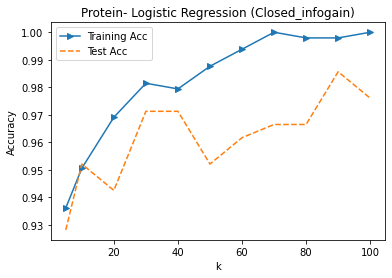

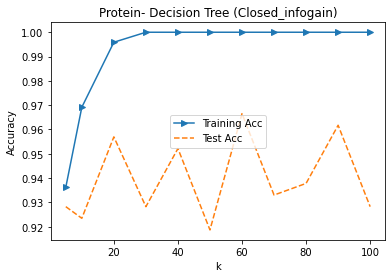

In [31]:
lr_train_acc=[]
lr_test_acc=[]
dt_train_acc=[]
dt_test_acc=[]

KS=[5,10,20,30,40,50,60,70,80,90,100]
for k in KS:
    print('Current k: ',k)
    top_k_seq=k_select_closed(positive_seqs,negative_seqs,k,P,N,total,score_type='infogain')
    frame=Create_df(top_k_seq,ds_positive.transactions,ds_negative.transactions)# creating the dataframe
    X_train, X_test, y_train, y_test = train_test_split(frame.iloc[:,:-1], frame.iloc[:,-1], test_size=0.3, random_state=42)
    """
    Logistic Regression
    """
    lr = LogisticRegression(random_state=0).fit(X_train, y_train.astype(int))
    lr_train_acc.append(lr.score(X_train, y_train.astype(int)))
    lr_test_acc.append(lr.score(X_test, y_test.astype(int)))
        
    """
    Decision Tree
    """
    dt = DecisionTreeClassifier(random_state=0).fit(X_train, y_train.astype(int))
    dt_train_acc.append(dt.score(X_train, y_train.astype(int)))
    dt_test_acc.append(dt.score(X_test, y_test.astype(int)))
    
## Plotting
plt.figure(1)
plt.plot(KS,lr_train_acc,'->',label='Training Acc')
plt.plot(KS,lr_test_acc,'--',label='Test Acc')
#plt.fill_between(KS,np.array(lr_train_acc)-0.002,np.array(lr_train_acc)+0.002,color='gray', alpha=0.2)
#plt.xlim(0, 10)
plt.title('Protein- Logistic Regression (Closed_infogain)')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Protein-Closedinfowracc-Logi.png')

plt.figure(2)
plt.plot(KS,dt_train_acc,'->',label='Training Acc')
plt.plot(KS,dt_test_acc,'--',label='Test Acc')
plt.title('Protein- Decision Tree (Closed_infogain)')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Protein-Closedinfowracc-DecTr.png')